In [81]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path
from monai.transforms import Compose, ScaleIntensityd, EnsureChannelFirstd, Resized, Lambdad, RandFlipd, RandRotated
import matplotlib.pyplot as plt
import numpy as np

In [15]:
ds_path_1 = r"C:\Python310\2021深度學習\xray_datasets\train\positive"
ds_path_2 = r"C:\Python310\2021深度學習\xray_datasets\train\negative"
ds_path_3 = r"C:\Python310\2021深度學習\xray_datasets\test\positive"
ds_path_4 = r"C:\Python310\2021深度學習\xray_datasets\test\negative"

print(f"Num of train positive: {len([name for name in os.listdir(ds_path_1) if os.path.isfile(os.path.join(ds_path_1, name))])}") #train/positive
print(f"Num of train negative: {len([name for name in os.listdir(ds_path_2) if os.path.isfile(os.path.join(ds_path_2, name))])}") #train/negative
print(f"Num of test positive: {len([name for name in os.listdir(ds_path_3) if os.path.isfile(os.path.join(ds_path_3, name))])}") #test/positive
print(f"Num of test negative: {len([name for name in os.listdir(ds_path_4) if os.path.isfile(os.path.join(ds_path_4, name))])}") #test/negative

Num of train positive: 125
Num of train negative: 551
Num of test positive: 118
Num of test negative: 290


In [45]:
# 定義MONAI transforms
xray_transforms = Compose([
    ScaleIntensityd(keys="image"),  # 先正規化
    ToTensord(keys="image"),        # 再轉為 tensor
])

In [46]:
class XRatDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform

        self.samples = [] # 蒐集所有圖片與標籤

        # positive = 1
        positive_path = self.root_dir / split / 'positive'
        if positive_path.exists():
            for img_path in positive_path.glob("*.jpeg"):
                self.samples.append((img_path, 1))
            for img_path in positive_path.glob("*.jpg"):
                self.samples.append((img_path, 1))
            for img_path in positive_path.glob("*.png"):
                self.samples.append((img_path, 1))

        # nagitive = 0
        nagitive_path = self.root_dir / split / 'negative'
        if nagitive_path.exists():
            for img_path in nagitive_path.glob("*.jpeg"):
                self.samples.append((img_path, 0))
            for img_path in nagitive_path.glob("*.jpg"):
                self.samples.append((img_path, 0))
            for img_path in nagitive_path.glob("*.png"):
                self.samples.append((img_path, 0))

        print(f"{split} dataset: {len(self.samples)}")
        print(f" positive: {len([s for s in self.samples if s[1] == 1])}")
        print(f" negative: {len([s for s in self.samples if s[1] == 0])}")
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = Image.open(img_path).convert('L') #載入影像，並轉為灰階
        image_array = np.array(image, dtype=np.float32) # MONAI transforms 需要轉為numpy array 
        image_array = image_array[np.newaxis, :, :] # 添加channel維度 (H, W) -> (1, H, W)

        data = {"image": image_array, "label": label, "image_path": str(img_path)}

        # 使用 transform
        if self.transform:
            data = self.transform(data)

        return data

In [49]:
# 測試資料集

train_dataset = XRatDataset(
    root_dir = r"C:\Python310\2021深度學習\xray_datasets",
    split = 'train',
    transform = xray_transforms
)

test_dataset = XRatDataset(
    root_dir = r"C:\Python310\2021深度學習\xray_datasets",
    split = 'test',
    transform = xray_transforms
)

print("\n=== Fist 3 samples ===")
for i in range(3):
    sample = train_dataset[i]
    print(f"Sample {i}")
    print(f"  Shape: {sample['image'].shape}")
    print(f"  Label: {'positive' if sample['label'] == 1 else 'negative'}")
    print(f"  Path: {sample['image_path']}")
    print(f"  Range: {sample['image'].min():.3f} ~ {sample['image'].max():.3f}")

train dataset: 676
 positive: 125
 negative: 551
test dataset: 408
 positive: 118
 negative: 290

=== Fist 3 samples ===
Sample 0
  Shape: torch.Size([1, 1307, 1793])
  Label: positive
  Path: C:\Python310\2021深度學習\xray_datasets\train\positive\01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg
  Range: 0.000 ~ 1.000
Sample 1
  Shape: torch.Size([1, 1544, 1605])
  Label: positive
  Path: C:\Python310\2021深度學習\xray_datasets\train\positive\03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg
  Range: 0.000 ~ 1.000
Sample 2
  Shape: torch.Size([1, 1558, 1504])
  Label: positive
  Path: C:\Python310\2021深度學習\xray_datasets\train\positive\1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg
  Range: 0.000 ~ 1.000


In [84]:
# 完整的訓練 transforms（包含資料增強）

train_transforms = Compose([
    Lambdad(keys="image", func=lambda x: x[np.newaxis, :, :] if len(x.shape) == 2 else x),
    Resized(keys="image", spatial_size=(512, 512), mode='bilinear'), # 統一尺寸 'nearest', 'bilinear', 'bicubic'
    RandFlipd(keys="image", prob=0.5, spatial_axis=0),
    RandRotated(keys="image", prob=0.5, range_x=15),
    ScaleIntensityd(keys="image"),
    ToTensord(keys="image"),
])

# 驗證/測試 transforms（不需要資料增強）

test_transforms = Compose([
    Lambdad(keys="image", func=lambda x: x[np.newaxis, :, :] if len(x.shape) == 2 else x),
    Resized(keys="image", spatial_size=(512, 512)), # 統一尺寸
    ScaleIntensityd(keys="image"),
    ToTensord(keys="image"),
])

In [85]:
train_dataset_final = XRatDataset(
    root_dir = r"C:\Python310\2021深度學習\xray_datasets",
    split = 'train',
    transform = train_transforms
)

test_dataset_final = XRatDataset(
    root_dir = r"C:\Python310\2021深度學習\xray_datasets",
    split = 'test',
    transform = test_transforms
)

print(f"Train sample shape: {train_dataset_final[0]['image'].shape}")
print(f"Test sample shape: {test_dataset_final[0]['image'].shape}")

train dataset: 676
 positive: 125
 negative: 551
test dataset: 408
 positive: 118
 negative: 290
Train sample shape: torch.Size([1, 512, 512])
Test sample shape: torch.Size([1, 512, 512])


=== Resized data ===


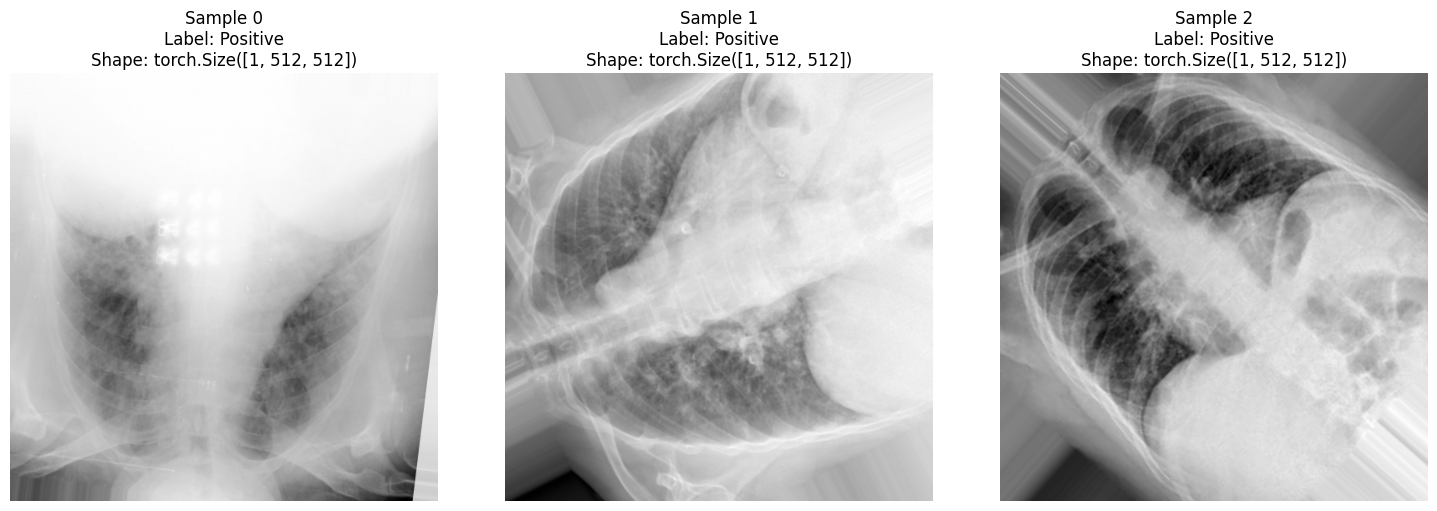

In [90]:
def show_resized_images(dataset, num_images=3):
    """顯示統一尺寸後的影像"""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    if num_images == 1:
        axes = [axes]
    
    for i in range(num_images):
        sample = dataset[i]
        image = sample['image']
        label = sample['label']
        
        # 轉換為顯示格式 (C, H, W) -> (H, W)
        if image.shape[0] == 1:
            display_image = image[0]
        else:
            display_image = image
            
        if torch.is_tensor(display_image):
            display_image = display_image.numpy()
        
        axes[i].imshow(display_image, cmap='gray')
        axes[i].set_title(f'Sample {i}\nLabel: {"Positive" if label == 1 else "Negative"}\nShape: {image.shape}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("=== Resized data ===")
show_resized_images(train_dataset_final, num_images=3)


=== Training Set Detailed Analysis ===
Total samples: 676
